# MDP Policy Iteration - Jack's Car Rental

* **Description:** Perform iterative policy iteration for the Jack's car rental problem
* **Reference:** Reinforcement Learning, An Introduction, Second Edition by Sutton, Barto
* **Section:** Section 4.3, Example 4.2, Pg. 81

In [1]:
#############################################################################################
# Copyright (C)																				#
# 2019 Aditya Rastogi(r.aditya0824@gmail.com)												#
# Permission given to modify the code as long as you keep this declaration at the top 		#
#############################################################################################

# Import required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import sys
import time
import datetime

In [3]:
train_start_time = datetime.datetime.now() # Start time
time.sleep(10)
train_end_time = datetime.datetime.now() # End time
train_time = ((train_end_time - train_start_time).total_seconds()) # Elapsed time
print("%0.6f" %train_time)

10.017114


# Define Classes and Functions

## Class: jcp

In [4]:
class jcp:
    """
    Define fixed parameters of the Jack's car rental problem
    """
    
    @staticmethod
    def max_cars(): # Maximum number of cars at each location
        return 20
    
    @staticmethod
    def γ(): # Discount rate
        return 0.9
    
    @staticmethod
    def credit_reward(): # Reward obtained for renting out a car
        return 10
    
    @staticmethod
    def moving_reward(): # Reward obtained (loss) for moving a car between locations
        return -2

## Class: poisson_

In [5]:
class poisson_:
    """
    Class that mimics a Poisson distribution but limits the values of n to values for which pmf is > eps
    """
    
    def __init__(self, λ):
        self.λ = λ
        
        ε = 0.01
        
        # [α , β] is the range of n's for which the pmf value is above ε
        self.α = 0
        state = 1
        self.vals = {}
        summer = 0
        
        while(1):
            if state == 1:
                temp = poisson.pmf(self.α, self.λ) 
                if(temp <= ε):
                    self.α+=1
                else:
                    self.vals[self.α] = temp
                    summer += temp
                    self.β = self.α+1
                    state = 2
            elif state == 2:
                temp = poisson.pmf(self.β, self.λ)
                if(temp > ε):
                    self.vals[self.β] = temp
                    summer += temp
                    self.β+=1
                else:
                    break    
        
        # normalizing the pmf, values of n outside of [α, β] have pmf = 0
        
        added_val = (1-summer)/(self.β-self.α)
        for key in self.vals:
            self.vals[key] += added_val
        
            
    def f(self, n):
        try:
            Ret_value = self.vals[n]
        except(KeyError):
            Ret_value = 0
        finally:
            return Ret_value

## Class: location

In [6]:
class location:
    """
    Class to store poisson distributions for a given location
    """
    
    def __init__(self, req, ret):
        self.α = req #value of lambda for requests
        self.β = ret #value of lambda for returns
        self.poissonα = poisson_(self.α) # Poisson distribution for request
        self.poissonβ = poisson_(self.β) # Poisson distribution for returns

## Function: apply_action

In [7]:
def apply_action(state, action):
    """
    Function to return new state given current state and action
    Notes: #Cars at either location has to lie between 0 and 20
    """
    return [max(min(state[0] - action, jcp.max_cars()),0) , max(min(state[1] + action, jcp.max_cars()),0)]

## Function: expected_reward

In [8]:
def expected_reward(state, action):
    global value
    """
    Function to return expected_reward given current state and action
    Environment is stochastic. For a given (s,a) pair, the environment can go into a new state s'
     and return a reward (r) with some probability p(s',r|s,a)
    Expected reward = Σs'[p(s',r|s,a) * (r + γ*v(s'))]
    state  : tuple of integers, #cars at A and at B
    action : #cars transferred from A to B,  -5 <= action <= 5 (negative action implies transfer from B to A)
    """
    
    ψ = 0 # Initialize reward
    new_state = apply_action(state, action) # Indicates state at the end of the day after cars transferred between 
                                            # the two locations
    # Compute reward for moving cars from one location to another (which is negative)     
    ψ = ψ + jcp.moving_reward() * abs(action)
    
    # On a given day, a certain number of cars will be rented from location A (Aα) and from location B (Bα)
    # A certain number of cars will be returned to location A (Aβ) and to location B (Bβ)
    # The tuple (Aα, Bα, Aβ, Bβ) is a random vector with a certain probability of occuring based on the 
    # Poisson distribution and also determines the reward obtained and the new state of the environment
    # Loop over all combinations of (Aα, Bα, Aβ, Bβ) to obtain expected reward.
    
    for Aα in range(A.poissonα.α, A.poissonα.β):
        for Bα in range(B.poissonα.α, B.poissonα.β):
            for Aβ in range(A.poissonβ.α, A.poissonβ.β):
                for Bβ in range(B.poissonβ.α, B.poissonβ.β):
                    """
                    Aα : sample of cars requested at location A
                    Aβ : sample of cars returned at location A
                    Bα : sample of cars requested at location B
                    Bβ : sample of cars returned at location B
                    ζ  : probability of this event happening
                    """

                    # all four variables are independent of each other
                    ζ = A.poissonα.vals[Aα] * B.poissonα.vals[Bα] * A.poissonβ.vals[Aβ] * B.poissonβ.vals[Bβ]
                    
#    action (which is the number of cars moved from A to B) should be less than the number of cars available 
#    at the location from which the cars are being moved. Not clear if this is taken care of properly
                    
                    valid_requests_A = min(new_state[0], Aα)
                    valid_requests_B = min(new_state[1], Bα)
                    
                    rew = (valid_requests_A + valid_requests_B)*(jcp.credit_reward())
                    
                    #calculating the new state based on the values of the four random variables
                    new_s = [0,0]
                    new_s[0] = max(min(new_state[0] - valid_requests_A + Aβ, jcp.max_cars()),0)
                    new_s[1] = max(min(new_state[1] - valid_requests_B + Bβ, jcp.max_cars()),0)
                    
                    #Bellman's equation
                    ψ += ζ * (rew + jcp.γ() * value[new_s[0]][new_s[1]])
                    
    return ψ

## Function: policy_evaluation

In [9]:
def policy_evaluation(print_flag = False):
    
    """
    Function to evaluate the policy using iterative policy estimation
    Ref: Iterative Policy Evaluation, for estimating V ~ Vπ, Pg. 75 of RL - Sutton
    """
    
    global value
    
    # here policy_evaluation has a static variable ε whose values decreases over time
    ε = policy_evaluation.ε
    policy_evaluation.ε /= 10 
    
    while(1): # Loop until δ < ϵ
        δ = 0 # Reset δ to 0.
        # Loop over all states
        # value[i][j] denotes the value of the state [i,j]
        for i in range(value.shape[0]):
            for j in range(value.shape[1]):
                old_val = value[i][j] # Current value of state (i, j)
                value[i][j] = expected_reward([i,j], policy[i][j]) # Updated value of state (i, j)
                δ = max(δ, abs(value[i][j] - old_val)) # Update δ
            if (print_flag):
                print(i, end = ' ')
                sys.stdout.flush()
        if (print_flag):
            print(δ, ϵ)
            sys.stdout.flush()
    
        if δ < ε:
            break

## Function: policy_improvement

In [10]:
def policy_improvement(print_flag = False):
    
    """
    Function to improve the policy using greedy action selection
    Ref: Policy Iteration, for estimating π ~ π*, Pg. 80 of RL - Sutton    
    """
    
    global policy
    
    policy_stable = True #Initialize policy_stable
    # Loop over all states
    for i in range(value.shape[0]):
        if (print_flag):
            print(i, end = ' ')
            sys.stdout.flush()        
        for j in range(value.shape[1]):
            old_action = policy[i][j] # Old action based on current policy
            max_act_val = None # Initialize max_act_val (Value of maximimizing action)
            max_act = None # Initialize max_act (Maximizing action)
            τ12 = min(i, 5) # if I have say 3 cars at the first location, then I can atmost move 3 from 1 to 2
            τ21 = -min(j, 5) # if I have say 2 cars at the second location, then I can atmost move 2 from 2 to 1
            for act in range(τ21, τ12+1): # Allowed action range for current state is (τ21, τ12)
                σ = expected_reward([i,j], act) # Obtain Q(s, act)
                # Evaluate max_act and max_act_val
                if max_act_val == None:
                    max_act_val = σ
                    max_act = act
                elif max_act_val < σ:
                    max_act_val = σ
                    max_act = act
            policy[i][j] = max_act # Obtain new deterministic policy for current state
            if old_action!= policy[i][j]: # Set policy_stable to False if optimum policy not reached for current state
                policy_stable = False
    if (print_flag):
        print()
    return policy_stable

## Function: save_policy

In [11]:
def save_policy():
    save_policy.counter += 1
    ax = sns.heatmap(policy, linewidth=0.5)
    ax.invert_yaxis()
    plt.savefig('./Figures/policy'+str(save_policy.counter)+'.png')
    plt.close()

## Function: save_value

In [12]:
def save_value():
    save_value.counter += 1
    ax = sns.heatmap(value, linewidth=0.5)
    ax.invert_yaxis()
    plt.savefig('./Figures/value'+ str(save_value.counter)+'.png')
    plt.close()

## Function: Value Iteration

In [13]:
def value_iteration(print_flag = False):
    
    """
    Function to run value iteration
    Ref: Value Iteration, for estimating π ~ π*, Pg. 83 of RL - Sutton    
    """
    
    global value
    global policy
    
    # Run value iteration loop first
    θ = 0.5 # Threshold for stopping value iteration
    iter_count = 1 # Iteration count of value iteration loop
    while(1): # Loop until δ < θ
        print("Running Iteration %d..." %iter_count, end = ', ')
        δ = 0 # Reset δ to 0.
        # Loop over all states
        # value[i][j] denotes the value of the state [i,j]
        for i in range(value.shape[0]):
            for j in range(value.shape[1]):
                old_val = value[i][j] # Current value of state (i, j)    
                # Estimate new value of state (i. j)    
                max_act_val = None # Initialize max_act_val (Value of maximimizing action)
                max_act = None # Initialize max_act (Maximizing action)
                τ12 = min(i, 5) # if I have say 3 cars at the first location, then I can atmost move 3 from 1 to 2
                τ21 = -min(j, 5) # if I have say 2 cars at the second location, then I can atmost move 2 from 2 to 1
                for act in range(τ21, τ12+1): # Allowed action range for current state is (τ21, τ12)
                    σ = expected_reward([i,j], act) # Obtain Q(s, act)
                    # Evaluate max_act and max_act_val
                    if max_act_val == None:
                        max_act_val = σ
                        max_act = act
                    elif max_act_val < σ:
                        max_act_val = σ
                        max_act = act
                value[i][j] = max_act_val # Updated value of state (i, j)
                policy[i][j] = max_act # Updated policy for state (i, j)
                δ = max(δ, abs(value[i][j] - old_val)) # Update δ
        
        iter_count += 1
        print("Max value at end of iteration is %d; δ = %0.2f" %(value.max(), δ))
        if (δ < θ):
            break

# Main Code

## Initializations

In [14]:
# Location initialisation
A = location(3, 3) # Location A: lambda = 3 for rentals and 3 for returns
B = location(4, 2) # Location B: lambda = 4 for rentals and 2 for returns

# Initializing the value and policy matrices. Initial policy has zero value for all states.
# State = (x, y) where x = number of cars at location A [Range = 0 to 20]
  # and y = number of cars at location B [Range = 0 to 20]
# Action = number of cars moved from location A to B [Range = -5 to 5]. 
  # Negative number indicates transfers from location B to A.
value = np.zeros((jcp.max_cars()+1, jcp.max_cars()+1))
policy = value.copy().astype(int) 

# Initial value of ε
policy_evaluation.ε = 50 # Threshold that determines accuracy to which policy will be evaluated
                         # Decreases with time after every full iteration of policy evaluation

In [15]:
print(A.poissonα.λ, A.poissonβ.λ) # λ-value at location A for rentals and returns
print(B.poissonα.λ, B.poissonβ.λ) # λ-value at location B for rentals and returns
print(value.shape, value.dtype) # Shape and data-type of value function
print(policy.shape, policy.dtype) # Shape and data-type of policy 
print(A.poissonα.α, A.poissonα.β, A.poissonβ.α, A.poissonβ.β) 
print(B.poissonα.α, B.poissonα.β, B.poissonβ.α, B.poissonβ.β)

3 3
4 2
(21, 21) float64
(21, 21) int32
0 8 0 8
0 10 0 7


## Policy Evaluation for π0

 π0 is the policy where no cars are moved between the two locations.
 
 This section is used to show how two runs of policy evaluation work for this policy

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 190.7422667431856 50
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 132.3288138607936 50
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 89.66201097313652 50
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 67.09773710887819 50
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 53.22356224698336 50
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 41.38141600199123 50



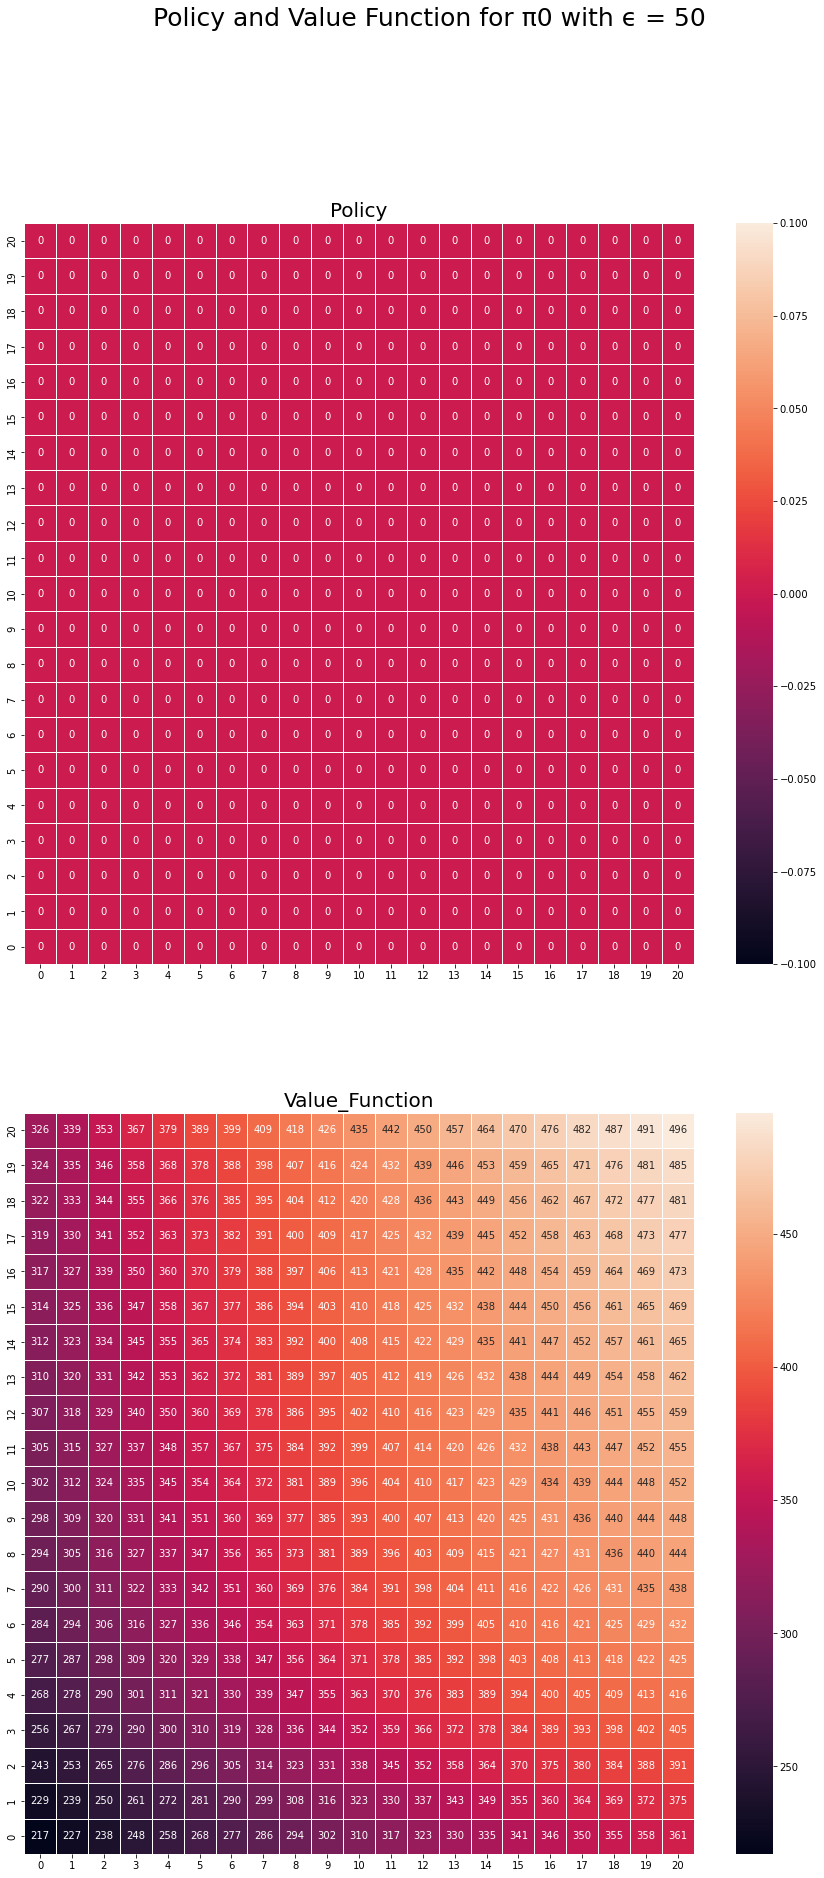

In [16]:
# Evaluate current policy
policy_evaluation(print_flag = True)
print()

fig, ax = plt.subplots(2, 1, figsize = (15, 30))
fig.suptitle("Policy and Value Function for π0 with ϵ = 50", fontsize = 25)
ax[0] = sns.heatmap(policy, linewidth=0.5, annot = True, ax = ax[0]) # Plot policy (= π0)
ax[0].set_title("Policy", fontsize = 20)
ax[0].invert_yaxis()

ax[1] = sns.heatmap(value, linewidth=0.5, annot = True, fmt = '0.0f', ax = ax[1])
ax[1].set_title("Value_Function", fontsize = 20) # Plot Value Function with ϵ = 50
ax[1].invert_yaxis()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 32.37450057618611 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 25.751715009623638 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21.46167983698149 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 18.052137698826243 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 15.148206176579038 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 12.683763845315355 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 10.598461105485853 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 8.838904302591288 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 7.358284664737198 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 6.115687692659776 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 5.075451140188136 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 4.206616906939928 5.0



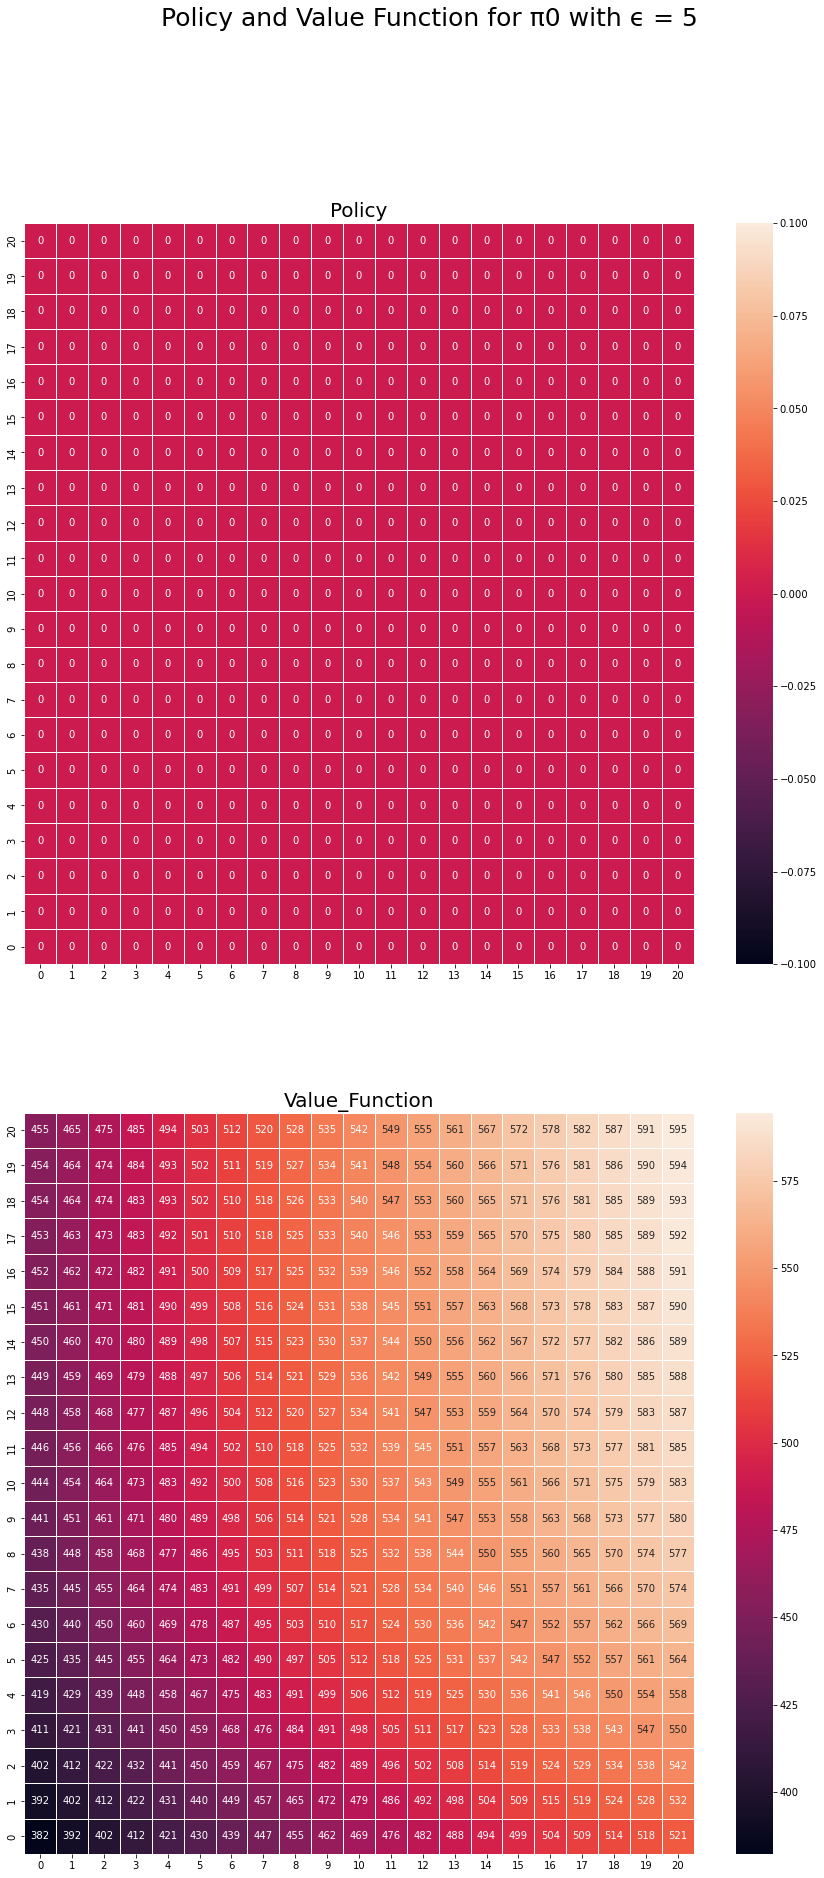

In [17]:
# Evaluate current policy again starting from previous value function but with lower ϵ.
policy_evaluation(print_flag = True)
print()

fig, ax = plt.subplots(2, 1, figsize = (15, 30))
fig.suptitle("Policy and Value Function for π0 with ϵ = 5", fontsize = 25)
ax[0] = sns.heatmap(policy, linewidth=0.5, annot = True, ax = ax[0]) # Plot policy (= π0)
ax[0].set_title("Policy", fontsize = 20)
ax[0].invert_yaxis()

ax[1] = sns.heatmap(value, linewidth=0.5, annot = True, fmt = '0.0f', ax = ax[1])
ax[1].set_title("Value_Function", fontsize = 20) # Plot Value Function with ϵ = 50
ax[1].invert_yaxis()

In [18]:
print("Minimum value [State (0,0)]: %d" %value.min())
print("Maximum value [State (20, 20)]: %d" %value.max())

Minimum value [State (0,0)]: 382
Maximum value [State (20, 20)]: 594


## Execute Policy Iteration Algorithm

### Trial runs

Perform one iteration of policy evaluation followed by policy improvement followed by policy evaluation

First iteration of policy evaluation
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 190.7422667431856 50
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 132.3288138607936 50
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 89.66201097313652 50
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 67.09773710887819 50
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 53.22356224698336 50
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 41.38141600199123 50

First iteration of policy improvement
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

Second iteration of policy evaluation
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 108.30002833852905 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 28.974428595453105 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 23.301431489076776 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 20.452321093917305 5.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 17.305046535861663 5.0
0 1 2 3

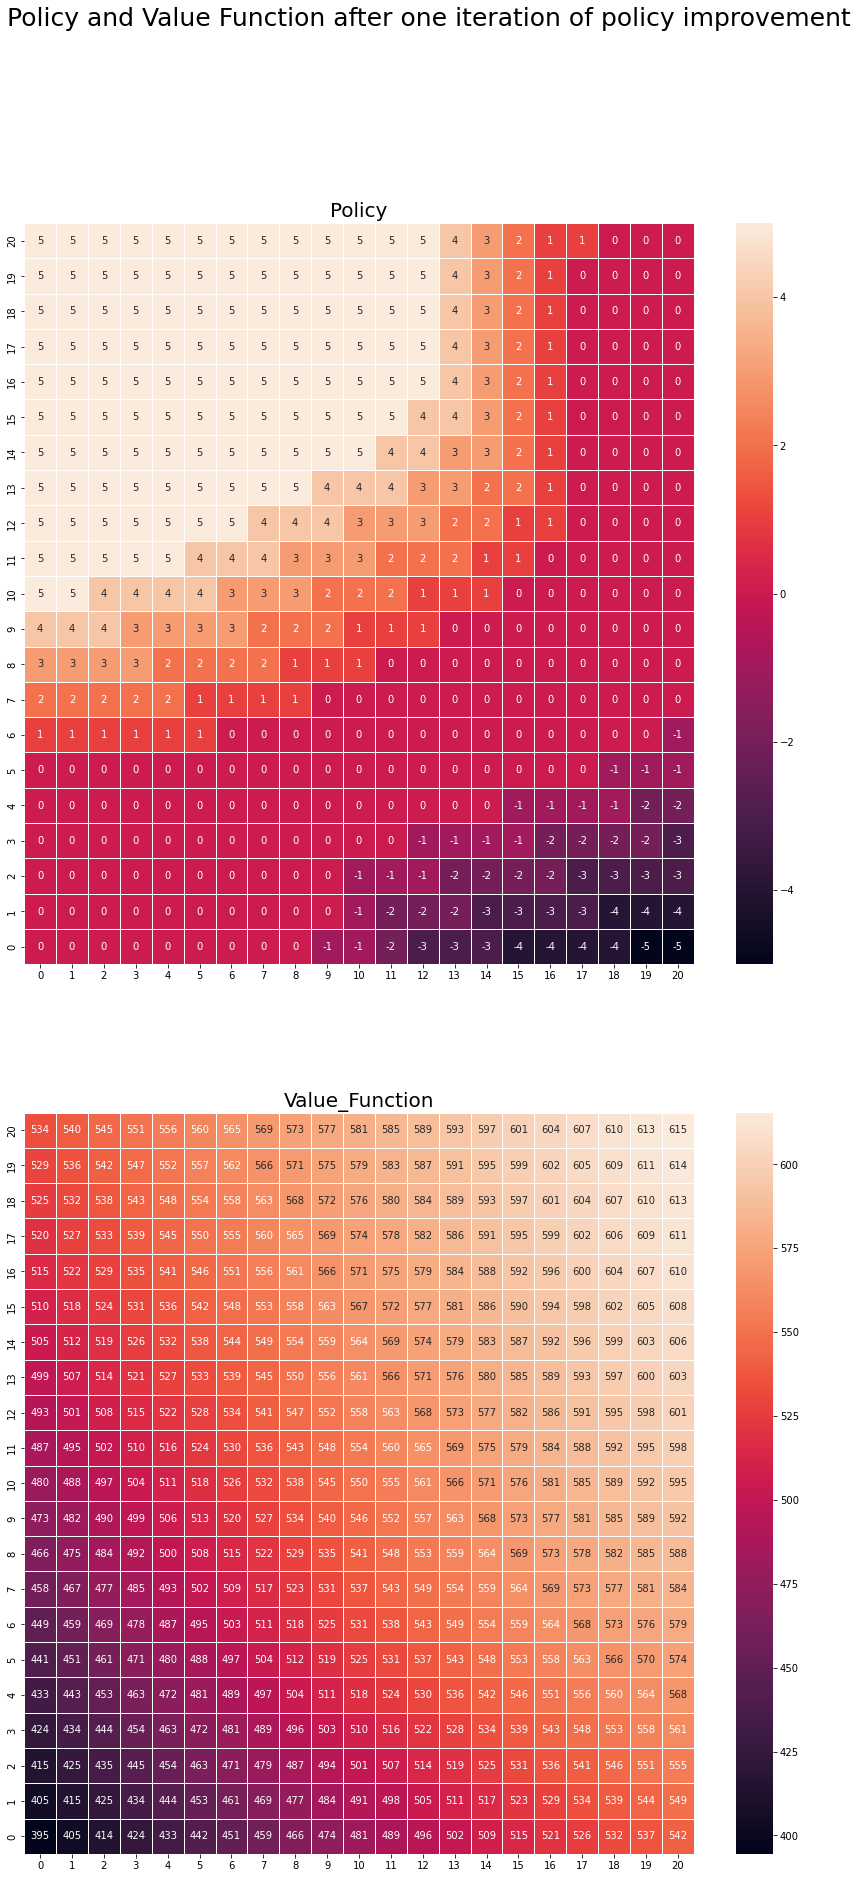

In [19]:
value = np.zeros((jcp.max_cars()+1, jcp.max_cars()+1)) # Initialize value to all zeros
policy = value.copy().astype(int) # Initialize policy to all zeros (no cars moved between the two locations for all states)

# Initial value of ε
policy_evaluation.ε = 50

# Execute trial run
print("First iteration of policy evaluation")
policy_evaluation(print_flag = True) # First iteration of policy evaluation; ϵ = 50
print()
print("First iteration of policy improvement")
ρ = policy_improvement(print_flag = True) # First iteration of policy improvement
print()
print("Second iteration of policy evaluation")
policy_evaluation(print_flag = True) # Second iteration of policy evaluation; ϵ = 5

fig, ax = plt.subplots(2, 1, figsize = (15, 30))
fig.suptitle("Policy and Value Function after one iteration of policy improvement", fontsize = 25)
ax[0] = sns.heatmap(policy, linewidth=0.5, annot = True, ax = ax[0])
ax[0].set_title("Policy", fontsize = 20)
ax[0].invert_yaxis()

ax[1] = sns.heatmap(value, linewidth=0.5, annot = True, fmt = '0.0f', ax = ax[1])
ax[1].set_title("Value_Function", fontsize = 20) # Plot Value Function with ϵ = 50
ax[1].invert_yaxis()

In [20]:
print("Minimum value [State (0,0)]: %d" %value.min())
print("Maximum value [State (20, 20)]: %d" %value.max())

Minimum value [State (0,0)]: 394
Maximum value [State (20, 20)]: 615


### Full policy iteration

In [21]:
value = np.zeros((jcp.max_cars()+1, jcp.max_cars()+1)) # Initialize value to all zeros
policy = value.copy().astype(int) # Initialize policy to all zeros (no cars moved between the two locations for all states)

# Initial value of ε
policy_evaluation.ε = 50

# Initialize counters
save_policy.counter = 0
save_value.counter = 0

# Run policy iteration
start_time = datetime.datetime.now() # Start time
print("Policy Iteration started at %s...\n" %(start_time.strftime("%H:%M:%S")))

while(1):
    print("Running Policy Iteration round #%d..." %save_policy.counter)
    policy_evaluation(False)
    ρ = policy_improvement(False)
    save_value()
    save_policy()
    if ρ == True:
        break

end_time = datetime.datetime.now() # End time
train_time = ((end_time - start_time).total_seconds())/60 # Elapsed time
print("\nPolicy Iteration completed at %s. Elapsed Time = %0.2f minutes" %(end_time.strftime("%H:%M:%S"), train_time))

Policy Iteration started at 13:47:33...

Running Policy Iteration round #0...
Running Policy Iteration round #1...
Running Policy Iteration round #2...
Running Policy Iteration round #3...
Running Policy Iteration round #4...

Policy Iteration completed at 14:15:50. Elapsed Time = 28.29 minutes


Minimum value [State (0,0)]: 415
Maximum value [State (20, 20)]: 629


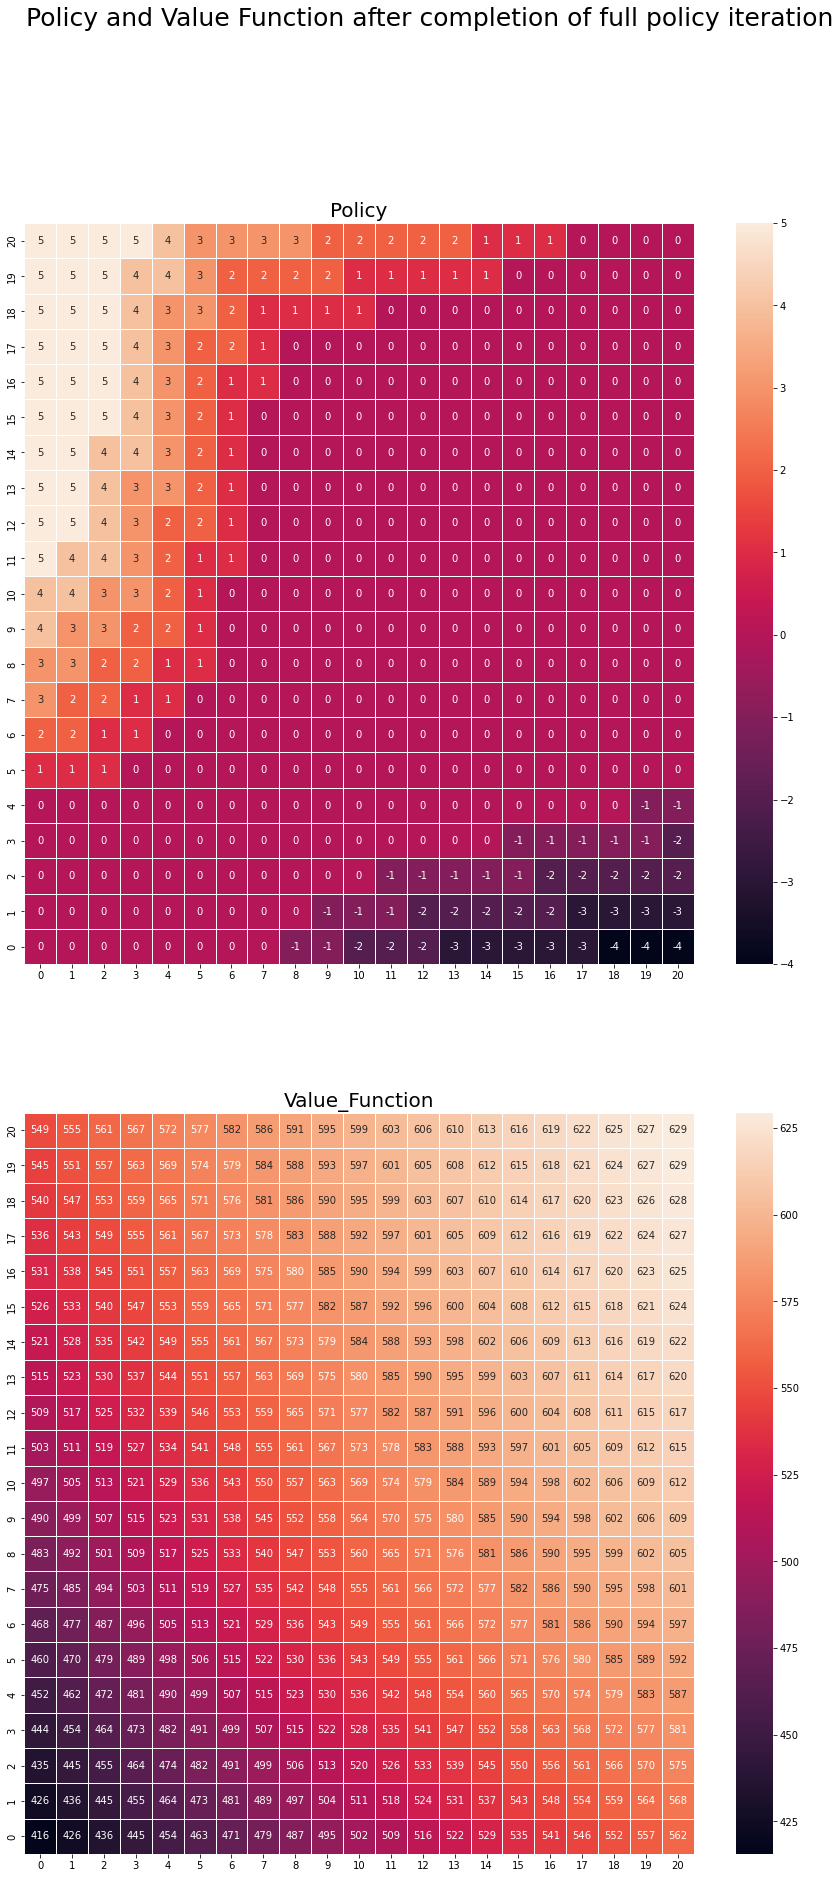

In [22]:
# Final policy and Value Function
fig, ax = plt.subplots(2, 1, figsize = (15, 30))
fig.suptitle("Policy and Value Function after completion of full policy iteration", fontsize = 25)
ax[0] = sns.heatmap(policy, linewidth=0.5, annot = True, ax = ax[0]) # Plot policy (= π0)
ax[0].set_title("Policy", fontsize = 20)
ax[0].invert_yaxis()

ax[1] = sns.heatmap(value, linewidth=0.5, annot = True, fmt = '0.0f', ax = ax[1])
ax[1].set_title("Value_Function", fontsize = 20) # Plot Value Function with ϵ = 50
ax[1].invert_yaxis()

print("Minimum value [State (0,0)]: %d" %value.min())
print("Maximum value [State (20, 20)]: %d" %value.max())

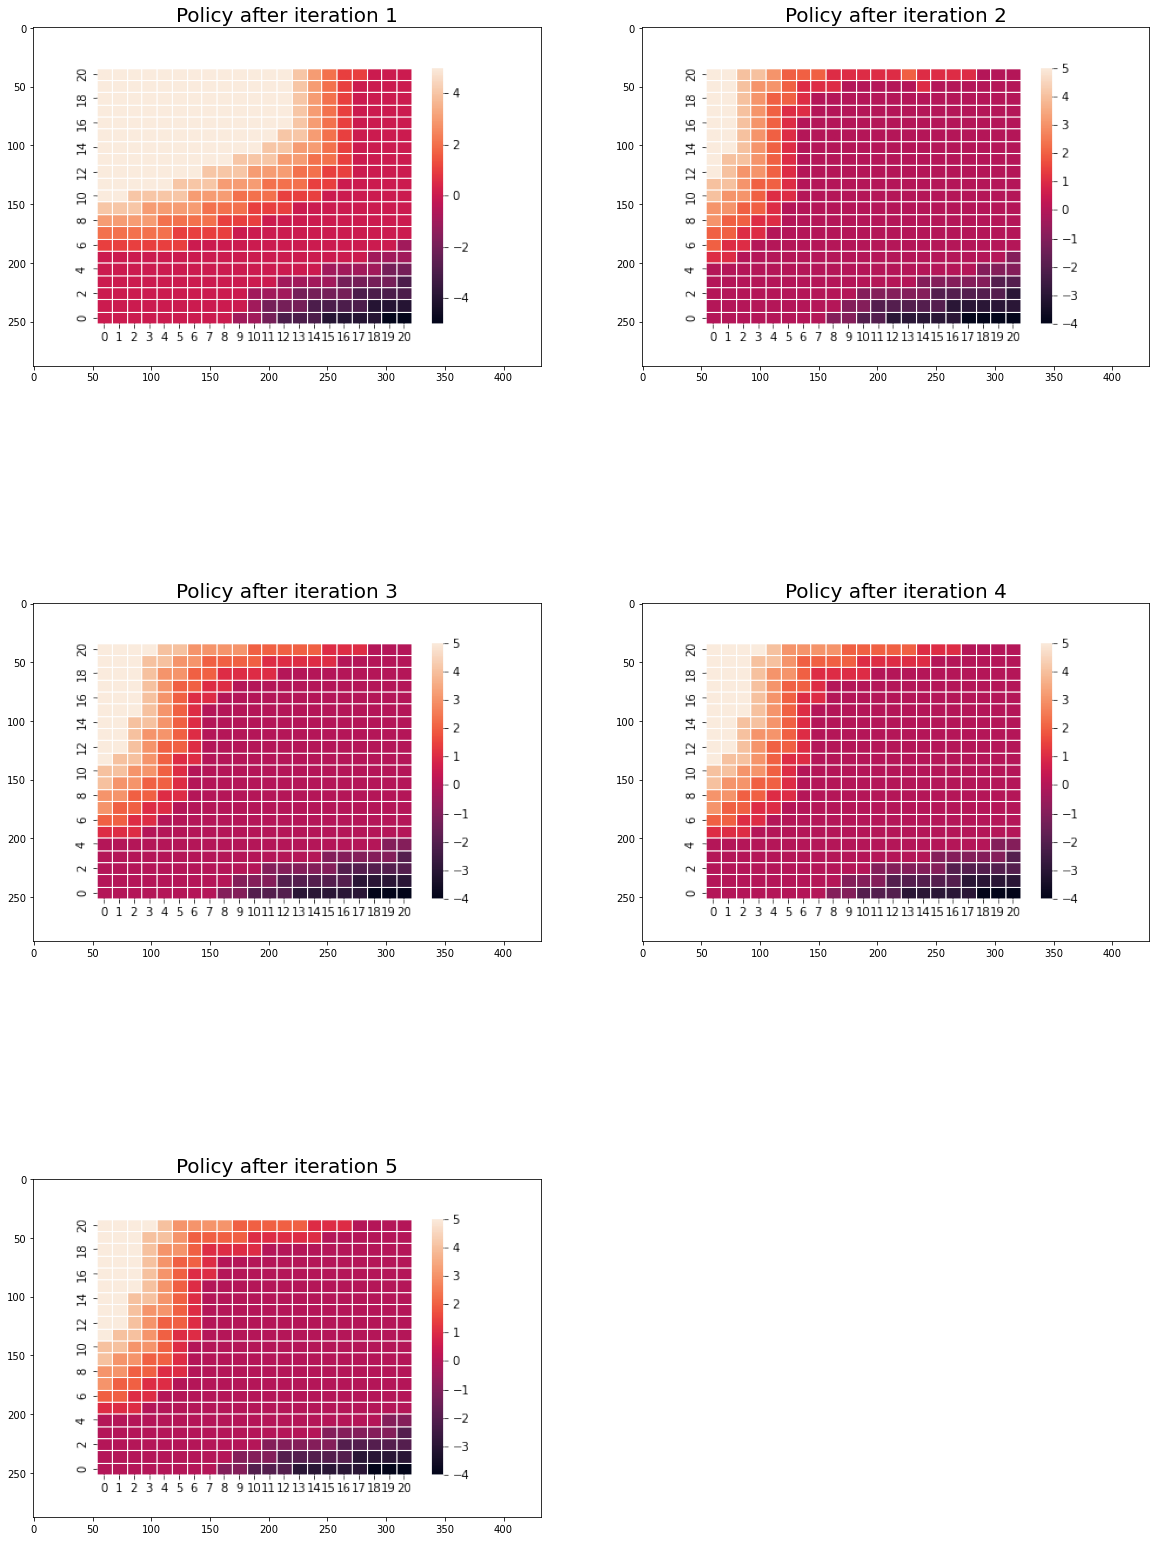

In [23]:
# Plot policy obtained after each iteration

fig = plt.figure(figsize = (2 * 10, 3 * 10))
for ind in range(save_policy.counter):
    ax = fig.add_subplot(3, 2, (ind + 1))
    temp_plot = plt.imread('./Figures/policy'+ str(ind + 1)+'.png')
    ax.set_title("Policy after iteration %d" %(ind+1), fontsize = 20)
    ax.imshow(temp_plot)
# plt.tight_layout()    

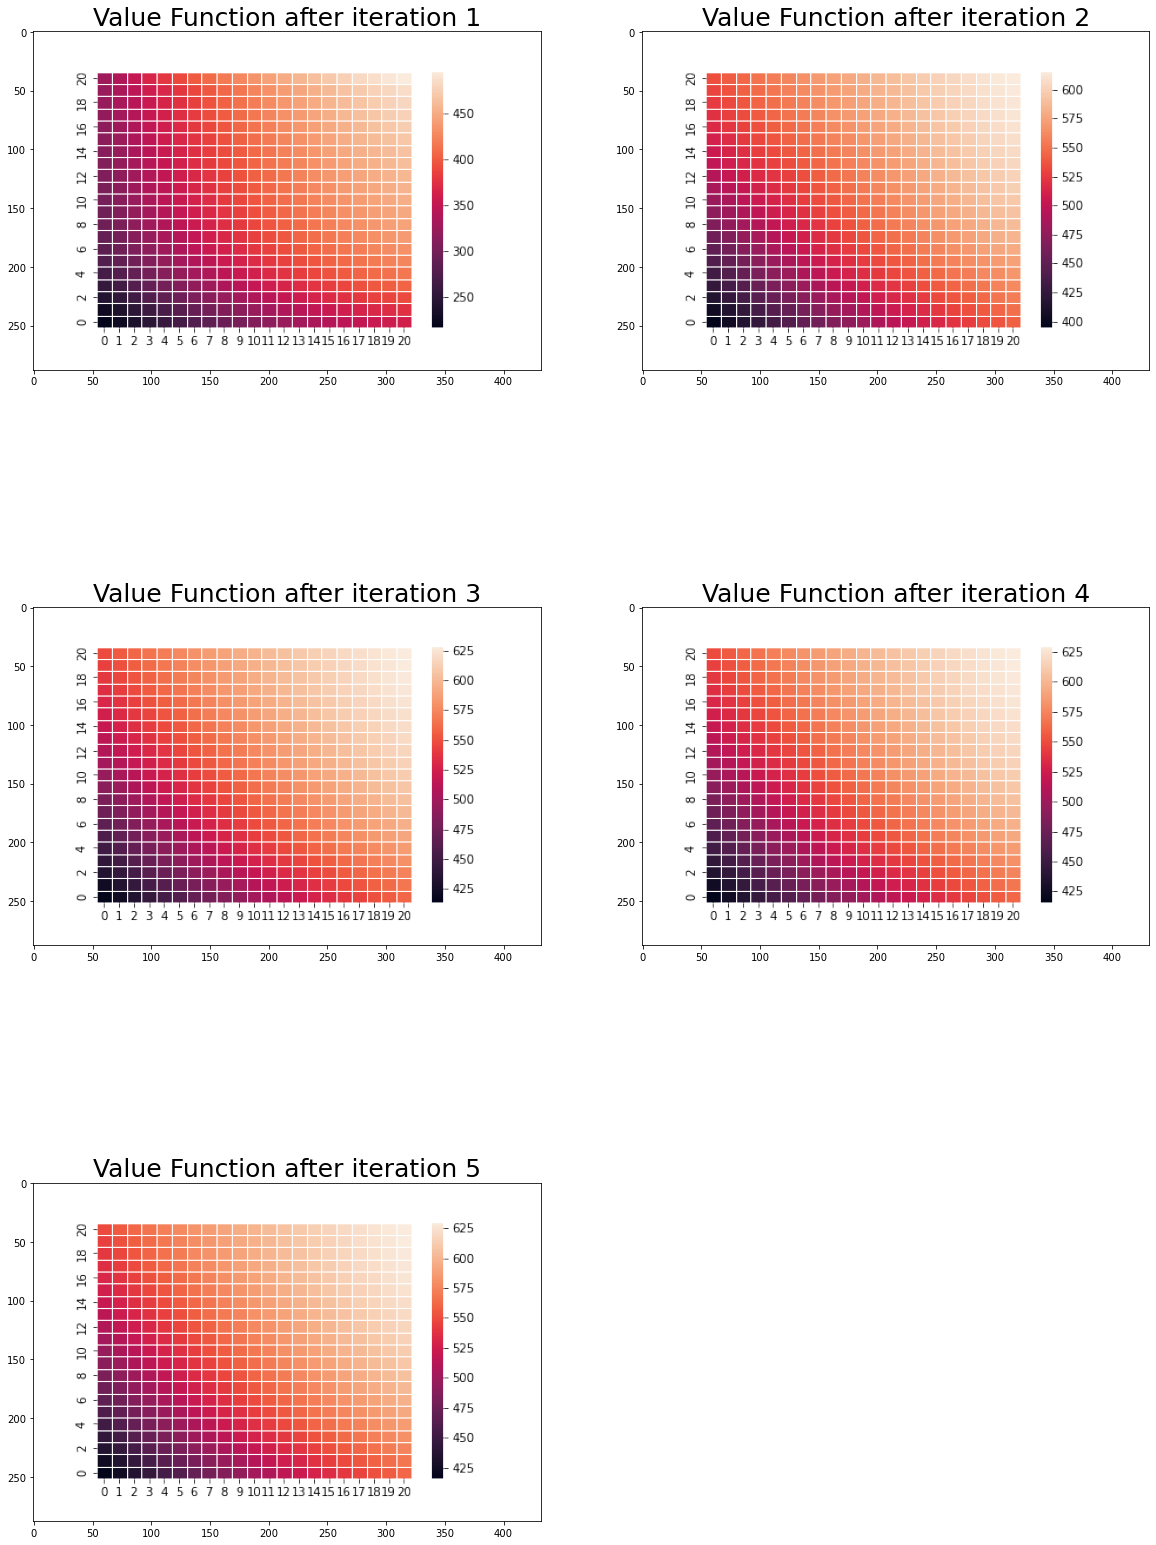

In [24]:
# Plot value function obtained after each iteration

fig = plt.figure(figsize = (2 * 10, 3 * 10))
for ind in range(save_value.counter):
    ax = fig.add_subplot(3, 2, (ind + 1))
    temp_plot = plt.imread('./Figures/value'+ str(ind + 1)+'.png')
    ax.set_title("Value Function after iteration %d" %(ind+1), fontsize = 25)
    ax.imshow(temp_plot)

## Execute Value Iteration Algorithm

In [25]:
# Initializations
value = np.zeros((jcp.max_cars()+1, jcp.max_cars()+1)) # Initialize value to all zeros
policy = value.copy().astype(int)

# Run Value iteration
start_time = datetime.datetime.now() # Start time
print("Value Iteration started at %s...\n" %(start_time.strftime("%H:%M:%S")))

value_iteration(print_flag = True)

end_time = datetime.datetime.now() # End time
train_time = ((end_time - start_time).total_seconds())/60 # Elapsed time
print("\nValue Iteration completed at %s. Elapsed Time = %0.2f minutes" %(end_time.strftime("%H:%M:%S"), train_time))

Value Iteration started at 14:16:01...

Running Iteration 1..., Max value at end of iteration is 295; δ = 295.77
Running Iteration 2..., Max value at end of iteration is 386; δ = 110.73
Running Iteration 3..., Max value at end of iteration is 445; δ = 87.19
Running Iteration 4..., Max value at end of iteration is 489; δ = 65.52
Running Iteration 5..., Max value at end of iteration is 521; δ = 49.30
Running Iteration 6..., Max value at end of iteration is 544; δ = 37.95
Running Iteration 7..., Max value at end of iteration is 562; δ = 30.85
Running Iteration 8..., Max value at end of iteration is 575; δ = 25.39
Running Iteration 9..., Max value at end of iteration is 585; δ = 20.86
Running Iteration 10..., Max value at end of iteration is 593; δ = 17.11
Running Iteration 11..., Max value at end of iteration is 600; δ = 14.03
Running Iteration 12..., Max value at end of iteration is 605; δ = 11.50
Running Iteration 13..., Max value at end of iteration is 609; δ = 9.43
Running Iteration 1

Minimum value [State (0,0)]: 413
Maximum value [State (20, 20)]: 628


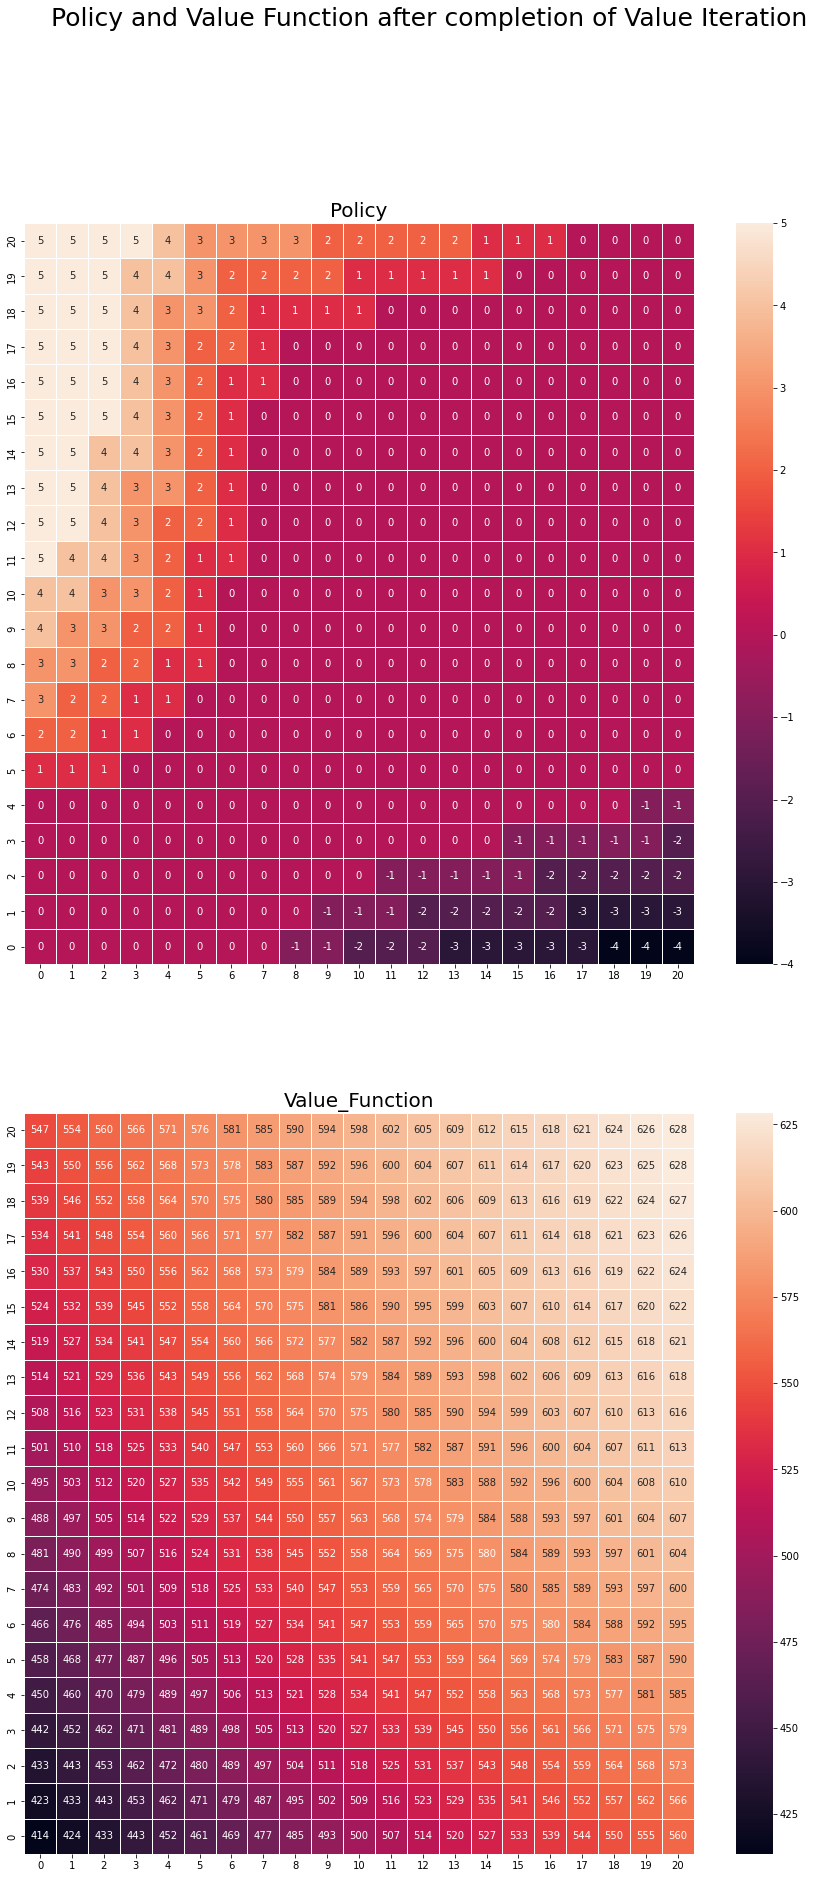

In [26]:
# Final policy and Value Function
fig, ax = plt.subplots(2, 1, figsize = (15, 30))
fig.suptitle("Policy and Value Function after completion of Value Iteration", fontsize = 25)
ax[0] = sns.heatmap(policy, linewidth=0.5, annot = True, ax = ax[0]) # Plot policy (= π0)
ax[0].set_title("Policy", fontsize = 20)
ax[0].invert_yaxis()

ax[1] = sns.heatmap(value, linewidth=0.5, annot = True, fmt = '0.0f', ax = ax[1])
ax[1].set_title("Value_Function", fontsize = 20) # Plot Value Function with ϵ = 50
ax[1].invert_yaxis()

print("Minimum value [State (0,0)]: %d" %value.min())
print("Maximum value [State (20, 20)]: %d" %value.max())